In [1]:
# main function
import numpy as np
import torch
import matplotlib.pyplot as plt
import botorch

from xopt.bayesian.algorithms import bayesian_exploration

from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

import os
SMOKE_TEST = os.environ.get('SMOKE_TEST')

# test function
from xopt.tests.evaluators import TNK


In [2]:
# To see log messages
from xopt import output_notebook
output_notebook()

In [3]:
"""
    Example where we must use a custom botorch model to make predictions. 
    We modify the test_TNK function with a wrapper to return Nan values for the y1 objective if one of the constraints are not satisfied.
    To accomidate this we define a ModelListGP model as a custom model to remove Nan values from the training data.

"""

# define a new test function that returns nans for y1 if c1 is not valid
def nan_test_TNK(x):
    outputs = TNK.evaluate_TNK(x)
    if outputs['c1'] < 0:
        outputs['y1'] = np.nan
        
    return outputs


# Get VOCS
VOCS = TNK.VOCS
VOCS['objectives'] = {'y1' : 'MINIMIZE'}

# add reference point
ref = torch.tensor((1.4, 1.4))

print(VOCS)
# Get evaluate function
EVALUATE = nan_test_TNK
n_steps = 30
generator_options = {}

if SMOKE_TEST:
    generator_options = {'batch_size': 1,
                           'num_restarts': 2,
                           'raw_samples': 2}
    n_steps = 3


# Run
init_x = torch.tensor([[0.9, 0.9], [0.6, 0.6]])
results = bayesian_exploration(VOCS, EVALUATE,
                               n_initial_samples=5,
                               initial_x=None,
                               n_steps=n_steps,
                               generator_options=generator_options)

{'name': 'TNK_test', 'description': 'Constrainted test function TNK. See Table V in https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf', 'simulation': 'test_TNK', 'variables': {'x1': [0, 3.14159], 'x2': [0, 3.14159]}, 'objectives': {'y1': 'MINIMIZE'}, 'constraints': {'c1': ['GREATER_THAN', 0], 'c2': ['LESS_THAN', 0.5]}, 'constants': {'a': 'dummy_constant'}}
started running optimization with generator: <xopt.bayesian.generators.exploration.BayesianExplorationGenerator object at 0x11eedd580>
submitting initial candidates
starting optimization loop
submitting candidates
[tensor([-0.7224,  1.3158, -0.2790,  0.7426, -1.0571], dtype=torch.float64), tensor([ -8.0597,  -4.5045,  -7.0631,  -4.6592, -14.0518,   5.4263],
       dtype=torch.float64), tensor([12.6970,  9.5391, 11.5619,  9.5007, 16.3489,  4.4728],
       dtype=torch.float64)]
submitting candidates
[tensor([-0.7224,  1.3158, -0.2790,  0.7426, -1.0571], dtype=torch.float64), tensor([ -8.0597,  -4.5045,  -7.0631,  -4.6592, -14.0518,   5.426

dict_keys(['variables', 'objectives', 'corrected_objectives', 'constraint_status', 'feasibility', 'model', 'constraints', 'corrected_constraints'])
tensor([[2.3135],
        [1.5020],
        [2.1369],
        [1.7302],
        [2.4467],
        [   nan],
        [   nan],
        [   nan],
        [1.0255],
        [1.4314],
        [   nan],
        [0.3280],
        [0.7482],
        [1.0412],
        [0.1327],
        [0.5626],
        [1.1225],
        [0.5149],
        [0.9226],
        [1.0369],
        [0.7940],
        [1.1785],
        [0.0755],
        [   nan],
        [   nan],
        [0.3360],
        [0.3889],
        [0.7076],
        [1.0746],
        [1.1920],
        [0.0611],
        [1.0387],
        [0.8530],
        [0.2960],
        [0.4240]], dtype=torch.float64)


Text(0, 0.5, '$x_2$')

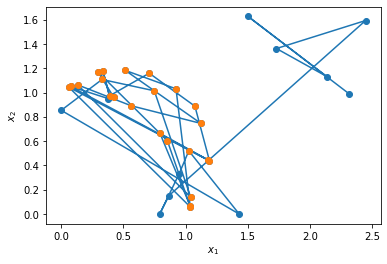

In [4]:
fig, ax = plt.subplots()
print(results.keys())
variables = results['variables']
print(results['objectives'])
valid = results['variables'][results['feasibility'].flatten()]
ax.plot(variables[:, 0], variables[:, 1], '-o')
ax.plot(valid[:, 0], valid[:, 1], 'o')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
